# Generate sample from 2D GZ with Euler-Maruyama

Saved data at iteration 0, total violation is 0
Saved data at iteration 1, total violation is 0
Saved data at iteration 2, total violation is 0
Saved data at iteration 3, total violation is 0
Saved data at iteration 4, total violation is 0
Saved data at iteration 5, total violation is 0
Saved data at iteration 6, total violation is 0
Saved data at iteration 7, total violation is 0
Saved data at iteration 8, total violation is 0
Saved data at iteration 9, total violation is 0
Saved data at iteration 10, total violation is 0
Saved data at iteration 11, total violation is 0
Saved data at iteration 12, total violation is 0
Saved data at iteration 13, total violation is 0
Saved data at iteration 14, total violation is 0
Saved data at iteration 15, total violation is 0
Saved data at iteration 16, total violation is 0
Saved data at iteration 17, total violation is 0
Saved data at iteration 18, total violation is 0
Saved data at iteration 19, total violation is 0
Saved data at iteration 20, to

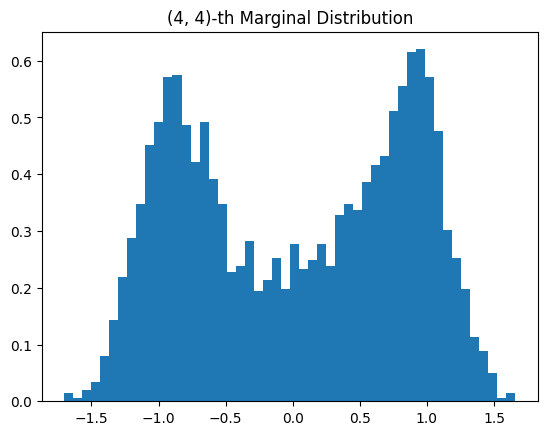

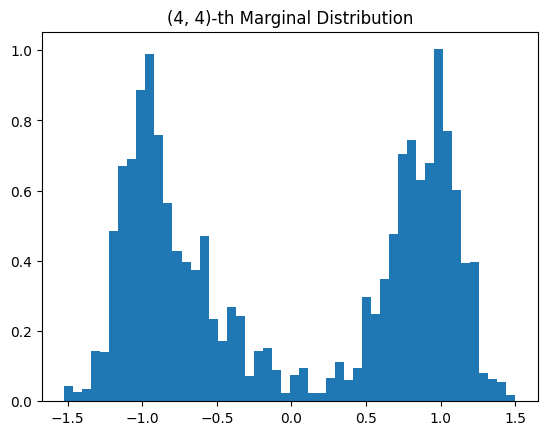

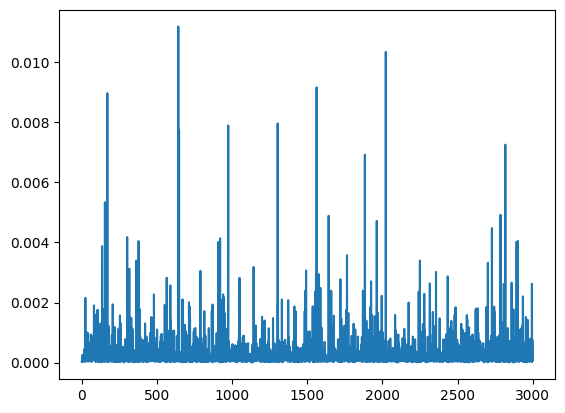

1.2928282070696875


In [41]:
import numpy as np
import os
import matplotlib.pyplot as plt

# Given constants
n = 8
d = n**2
h = 1 / (n + 1)
λ = 0.02
β0 = 7  # High temperature warm-up 

β = 14  # Low temperature
AIS_steps = 100 
dβ = (β - β0) / AIS_steps
V_grid = np.arange(β0,β+dβ,dβ) / β  # grid points used to compute effective potential

scale = 200
dt = 0.0005 * scale
N = int(1*scale/dt)  # Interested in T = 1
dt = 1*scale/N  # Correct for small deviation

l_MALA = True  # MALA option
l_AIS = True  # AIS option
N_AIS_MALA = 100  # Number of MALA steps per AIS step

BATCH_SIZE = 100  # Set your desired batch size

data_path = f"./Saved_Data/2D_GZ_data_d_{d}.npz"

# Hyperparameters
hyperparameters = {
    "d": d,
    "h": h,
    "λ": λ,
    "β": β,
    "dt": dt,
    "N": N,
    "BATCH_SIZE": BATCH_SIZE
}

# # Create directory if it doesn't exist
# if not os.path.exists("./Saved_Data"):
#     os.makedirs("./Saved_Data")

# # Load existing data or initialize
# if os.path.exists(data_path):
#     with np.load(data_path) as data:
#         all_samples = data['samples']
# else:
#     all_samples = np.empty((0, n + 2, n + 2))

if os.path.exists(data_path):
    os.remove(data_path)

all_samples_β0 = np.empty((0, n + 2, n + 2))
if l_AIS:
    all_samples = np.empty((0, n + 2, n + 2))
    all_log_weights = np.empty((0))

def V(U):
    # potential energy V
    return ( λ/h**2/2 * (
        np.sum((U - np.roll(U, 1, axis=1))**2, axis = (1,2)) + np.sum((U - np.roll(U, -1, axis=1))**2, axis = (1,2))
        + np.sum((U - np.roll(U, 1, axis=2))**2, axis = (1,2)) + np.sum((U - np.roll(U, -1, axis=2))**2, axis = (1,2))
    ) + np.sum(((1 - U**2)**2)[:,1:-1,1:-1], axis = (1,2)) /4/λ ) / d

def V_grad(U):
    """
    Compute the gradient of the potential energy V for a periodic domain.
    
    Args:
    - U (np.ndarray): Input tensor for which the gradient is computed.
    
    Returns:
    - np.ndarray: Gradient of the potential energy V.
    """
    return ( λ/h**2 * (
        4*U - np.roll(U, 1, axis=1) - np.roll(U, -1, axis=1) - np.roll(U, 1, axis=2) - np.roll(U, -1, axis=2)
    ) - U * (1 - U**2) /λ ) / d

def V_eff(AIS_step, U):
    return V_grid[AIS_step] * V(U)

def V_grad_eff(AIS_step, U):
    return V_grid[AIS_step] * V_grad(U)

def Langevin_step(U,β,V,V_grad,l_MALA=True):
    dW = np.sqrt(dt) * np.random.randn(BATCH_SIZE, n + 2, n + 2)
    
    U_tmp = U.copy()
    U_tmp[:, 1:-1, 1:-1] += (-V_grad(U_tmp)[:, 1:-1, 1:-1] * dt + np.sqrt(2/β) * dW[:, 1:-1, 1:-1])

    count = np.sum(U_tmp > 2.5) + np.sum(U_tmp <-2.5)
    U_tmp[U_tmp > 2.5] = 2.5
    U_tmp[U_tmp < -2.5] = -2.5

    if l_MALA:
        log_acceptance_ratio = np.minimum(0.0, - β * (V(U_tmp) - V(U)) \
                                      - β/4/dt * (np.sum(((U - U_tmp + dt * V_grad(U_tmp))[:,1:-1,1:-1])**2,axis=(1,2)) \
                                                      - np.sum(((U_tmp - U + dt * V_grad(U))[:,1:-1,1:-1])**2,axis=(1,2))))
        # Accept or reject
        accept = np.log(np.random.uniform(size=U.shape[0])) < log_acceptance_ratio

        # print(np.sum(accept))
    
        return np.where(accept[:, None, None], U_tmp, U), count
    else:
        return U_tmp, count

count = 0

for iteration in range(30):

    # U = np.zeros((BATCH_SIZE, n + 2, n + 2))  # Initialize at each iteration
    U = np.ones((BATCH_SIZE, n + 2, n + 2))  # Initialize at each iteration
    U[:,0,:] = 0.0
    U[:,-1,:] = 0.0
    U[:,:,0] = 0.0
    U[:,:,-1] = 0.0
    
    # Creating samples for 2D Ginzburg Landau
    for _ in range(N):
        U, count_ = Langevin_step(U,β0,V,V_grad,l_MALA)
        count += count_

    print(f'Saved data at iteration {iteration}, total violation is {count}')

    all_samples_β0 = np.concatenate((all_samples_β0, U), axis=0)

    if l_AIS:
        log_weights = np.zeros(BATCH_SIZE)
        for AIS_step in range(1,AIS_steps+1):
            
            # Reweighting
            log_weights += - β * (V_eff(AIS_step, U) - V_eff(AIS_step - 1, U))
            
            # MALA
            if AIS_step < AIS_steps:
                V_eff_tmp = lambda U : V_eff(AIS_step, U)
                V_grad_eff_tmp = lambda U : V_grad_eff(AIS_step, U)
                
                for _ in range(N_AIS_MALA):
                    U, _ = Langevin_step(U,β,V_eff_tmp,V_grad_eff_tmp,l_MALA) 

        all_samples = np.concatenate((all_samples, U), axis=0)
        all_log_weights = np.concatenate((all_log_weights, log_weights), axis=0)

    # Save the accumulated data
    if l_AIS:
        np.savez(data_path, samples=all_samples, log_weights=all_log_weights, hyperparameters=hyperparameters)
    else:
        np.savez(data_path, samples=all_samples_β0, hyperparameters=hyperparameters)

print(f'total number of violation is {count}')

# Visualization of the (n/2,n/2)-th marginal distribution
samples_1_mar = all_samples_β0[:, round(n/2), round(n/2)]  # Extract the d/2-th bit from each sample
plt.hist(samples_1_mar, bins=50, density=True)
# plt.hist(eighth_samples, bins=50, density=True)
plt.title(f"{round(n/2),round(n/2)}-th Marginal Distribution")
# plt.savefig('test1.png',bbox_inches='tight')
plt.show()

if l_AIS:
    # Normalize weights (convert log-weights to normalized weights)
    all_log_weights -= np.max(all_log_weights)  # Avoid numerical overflow
    weights = np.exp(all_log_weights)
    normalized_weights = weights / np.sum(weights)
    
    # Visualization of the (d/2)-th marginal distribution
    samples_1_mar = all_samples[:, round(n/2), round(n/2)]  # Extract the (n/2,n/2)-th bit from each sample
    plt.hist(samples_1_mar, bins=50, density=True, weights = normalized_weights)
    # plt.hist(eighth_samples, bins=50, density=True)
    plt.title(f"{round(n/2),round(n/2)}-th Marginal Distribution")
    plt.savefig('test1.png',bbox_inches='tight')
    plt.show()
    
    plt.plot(normalized_weights)
    plt.show()
    
    print(np.var(np.log(normalized_weights)))

In [28]:
# # Visualization of the (n/2,n/2)-th marginal distribution
# samples_1_mar = all_samples_β0[:, round(n/2), round(n/2)]  # Extract the d/2-th bit from each sample
# plt.hist(samples_1_mar, bins=50, density=True)
# # plt.hist(eighth_samples, bins=50, density=True)
# plt.title(f"{round(n/2),round(n/2)}-th Marginal Distribution")
# # plt.savefig('test1.png',bbox_inches='tight')
# plt.show()